In [1]:
import openvino as ov
import numpy as np
import sys
import cv2
from PIL import Image
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import normalize

In [2]:
core = ov.Core()

In [29]:
model = core.read_model(model="./model/human-pose-estimation.xml")
compiled_model = core.compile_model(model=model, device_name="CPU")

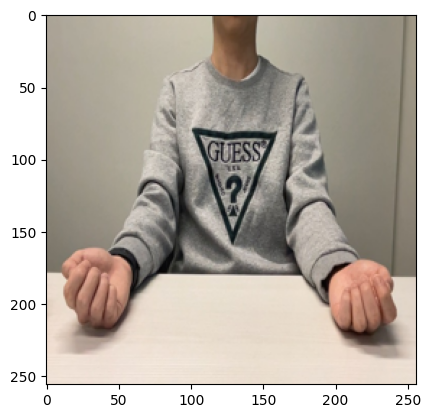

In [30]:
infer_request = compiled_model.create_infer_request()

image = Image.open("./test.jpg")
image = image.resize((256, 256))
image.load()
image = np.asarray(image, dtype=np.float32)

image = np.expand_dims(image, axis=0)
image = np.ascontiguousarray(np.transpose(image, (0, 3, 1, 2)))

temp = np.squeeze(image, axis=0)
temp = np.transpose(temp, (1, 2, 0))
plt.imshow(np.uint8(temp))

input_tensor = ov.Tensor(array=image, shared_memory=True)
infer_request.set_input_tensor(input_tensor)

In [31]:
infer_request.start_async()
infer_request.wait()

In [32]:
output = infer_request.get_output_tensor()
output_buffer = output.data

In [33]:
output_buffer = np.squeeze(output_buffer, axis=0)
output_buffer = np.transpose(output_buffer, axes=(1, 2, 0))
heatmaps = cv2.resize(
    output_buffer, (256, 256), fx=8, fy=8, interpolation=cv2.INTER_CUBIC
)

In [34]:
def extract_keypoints(heatmap, min_confidence=-20):
    ind = np.unravel_index(np.argmax(heatmap, axis=None), heatmap.shape)
    if heatmap[ind] < min_confidence:
        ind = (-1, -1)
    else:
        ind = (int(ind[1]), int(ind[0]))
    return ind

In [35]:
keypoints = []
for kpt_idx in range(16):
    keypoints.append(extract_keypoints(heatmaps[:, :, kpt_idx]))

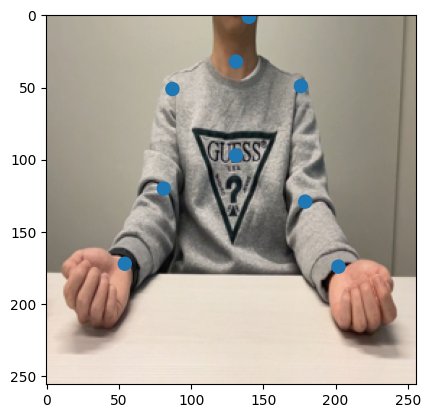

In [36]:
kpt_names = [
    "r_ank",
    "r_kne",
    "r_hip",
    "l_hip",
    "l_kne",
    "l_ank",
    "pel",
    "spi",
    "nec",
    "hea",
    "r_wri",
    "r_elb",
    "r_sho",
    "l_sho",
    "l_elb",
    "l_wri",
]
colors = [
    (255, 0, 0),
    (255, 0, 0),
    (255, 0, 0),
    (0, 0, 255),
    (0, 0, 255),
    (0, 0, 255),
    (0, 255, 0),
    (0, 255, 0),
    (0, 255, 0),
    (0, 255, 0),
    (255, 0, 0),
    (255, 0, 0),
    (255, 0, 0),
    (0, 0, 255),
    (0, 0, 255),
    (0, 0, 255),
]

fig, ax = plt.subplots(1)
ax.set_aspect("equal")

image = np.squeeze(image, 0)
image = np.transpose(image, (1, 2, 0))
ax.imshow(np.uint8(image))

arr = []

for id in range(7, 16):
    keypoint = keypoints[id]
    if keypoint[0] != -1:
        ax.add_patch(Circle((int(keypoint[0]), int(keypoint[1]))))
        arr.extend((keypoint[0], keypoint[1]))

Using cache found in /Users/stevenhyun/.cache/torch/hub/milesial_Pytorch-UNet_master
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


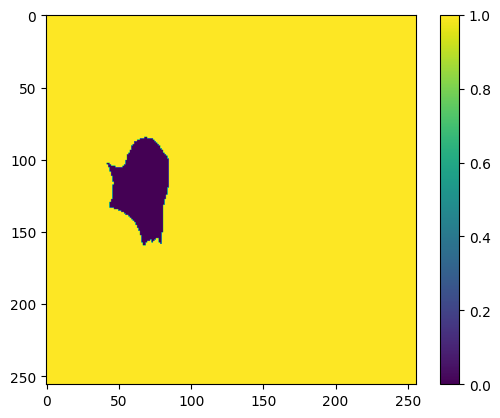

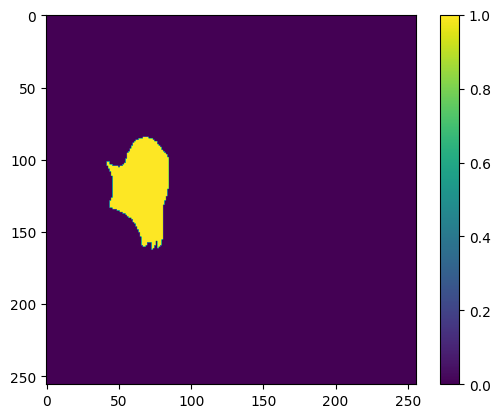

In [37]:
device = torch.device("cpu")
# model = UNet(3, 1)
model = torch.hub.load(
    "milesial/Pytorch-UNet",
    "unet_carvana",
    pretrained=False,
    scale=1,
)
model.load_state_dict(torch.load("./unet.pth", map_location=device)["model"])
model = model.to(device)
model.eval()

# image = np.asarray(Image.open(r"./original/Photo on 2023-10-19 at 6.18 PM.jpg"), dtype=np.float32)
image = np.asarray(Image.open(r"./test3.jpg").convert("RGB"), dtype=np.float32)

image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_CUBIC) / 255

image = image.transpose((2, 0, 1))

image = torch.from_numpy(image).to(device)

image = normalize(image, mean=(0.5687, 0.5434, 0.5152), std=(0.2508, 0.2399, 0.2307))

plt.imshow(image.permute(1, 2, 0).cpu().numpy())
print(image.shape)

image = torch.unsqueeze(image, 0)

output = model(image)

output_1 = np.transpose(
    np.squeeze(torch.sigmoid(output.detach()).cpu().numpy(), 0), (1, 2, 0)
)[:, :, 0]
output_2 = np.transpose(
    np.squeeze(torch.sigmoid(output.detach()).cpu().numpy(), 0), (1, 2, 0)
)[:, :, 1]
plt.imshow((output_1 >= 0.5))
plt.colorbar()
plt.figure()
plt.imshow((output_2 > 0.5))
plt.colorbar()

19.080978672873552


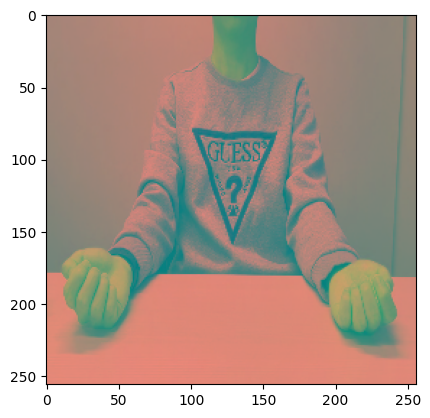

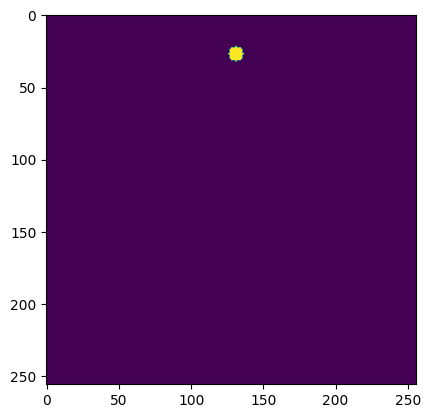

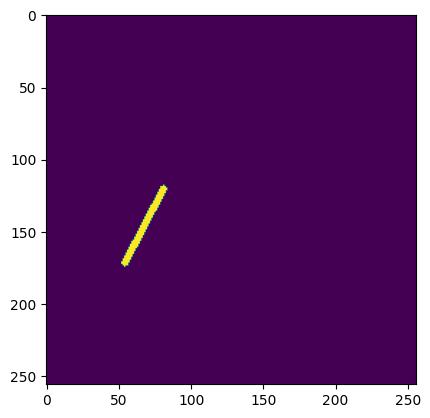

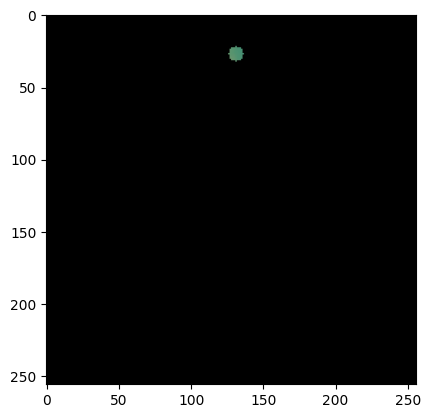

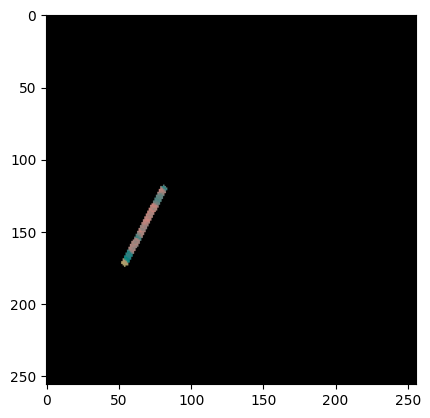

In [39]:
def _compare_patches(patch1, patch2):
    # Convert patches to a color space better suited for skin color analysis
    patch1_cb = patch1[:, :, 1][patch1[:, :, 1] != 0]
    patch1_cr = patch1[:, :, 2][patch1[:, :, 2] != 0]

    patch2_cb = patch2[:, :, 1][patch2[:, :, 1] != 0]
    patch2_cr = patch2[:, :, 2][patch2[:, :, 2] != 0]

    # Calculate the mean color values of the patches
    mean1_1, std1_1 = np.mean(patch1_cb), np.std(patch1_cb)
    mean2_1, std2_1 = np.mean(patch1_cr), np.std(patch2_cr)

    mean1_2, std1_2 = np.mean(patch2_cb), np.std(patch2_cb)
    mean2_2, std2_2 = np.mean(patch2_cr), np.std(patch2_cr)

    distance = np.sqrt(
        (mean1_1 - mean1_2) ** 2
        + (mean2_1 - mean2_2) ** 2
        + (std1_1 - std1_2) ** 2
        + (std2_1 - std2_2) ** 2
    )

    print(distance)


def skin_tone(pose_ret, seg_image, image, radius=5):
    """Get the skin tone of the person in the image

    Args:
        pose_ret (int []): array of size 18, containing the pose estimation result
        seg_ret (str): path to the segmentation result
        image (np.ndarray): the image
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    plt.figure()
    plt.imshow(image)

    neck_x, neck_y = pose_ret[2:4]

    mask_neck = np.zeros(image.shape[:2], dtype="uint8")

    cv2.circle(mask_neck, (neck_x, neck_y - radius), radius, 255, -1)
    plt.figure()
    plt.imshow(mask_neck)

    patch1 = cv2.bitwise_and(image, image, mask=mask_neck)

    mask_arm = np.zeros(image.shape[:2], dtype="uint8")

    r_wrist_x, r_wrist_y = pose_ret[6], pose_ret[7]
    r_elbow_x, r_elbow_y = pose_ret[8], pose_ret[9]

    cv2.line(mask_arm, (r_elbow_x, r_elbow_y), (r_wrist_x, r_wrist_y), 255, 3)

    plt.figure()
    plt.imshow(mask_arm)

    patch2 = cv2.bitwise_and(image, image, mask=mask_arm)

    plt.figure()
    plt.imshow(patch1)
    plt.figure()
    plt.imshow(patch2)
    _compare_patches(patch1, patch2)


image = cv2.imread("./test.jpg")
image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_CUBIC)

skin_tone(arr, None, image)

In [ ]:
import math

CUFF_SIZE = 12.5  # cm

print(arr)

r_wrist_x, r_wrist_y = arr[6], arr[7]
r_elbow_x, r_elbow_y = arr[8], arr[9]
r_shoulder_x, r_shoulder_y = arr[10], arr[11]

r_low_arm_slope = (r_elbow_y - r_wrist_y) / (r_elbow_x - r_wrist_x)
r_low_arm_int = r_elbow_y - r_low_arm_slope * r_elbow_x

r_up_arm_slope = (r_elbow_y - r_shoulder_y) / (r_elbow_x - r_shoulder_x)
r_up_arm_int = r_elbow_y - r_up_arm_slope * r_elbow_x

left = (80, 100)
down = (97, 102)

right = (104, 55)
up = (88, 52)

midpoint_d = (left[0] + down[0]) / 2, (left[1] + down[1]) / 2
midpoint_u = (right[0] + up[0]) / 2, (right[1] + up[1]) / 2

midpoint_dist = math.sqrt(
    (midpoint_d[0] - midpoint_u[0]) ** 2 + (midpoint_d[1] - midpoint_u[1]) ** 2
)
midpoint_r_dist = CUFF_SIZE / midpoint_dist


def plot_line(slope, int):
    x = np.arange(0, 256)
    y = slope * x + int
    y = y.clip(0, 256)
    return x, y


line_slope = (left[1] - down[1]) / (left[0] - down[0])
line_int = left[1] - line_slope * left[0]

line2_slope = (right[1] - up[1]) / (right[0] - up[0])
line2_int = right[1] - line2_slope * right[0]

# find the intersection between line_slope and r_up_arm_slope
x = (r_up_arm_int - line_int) / (line_slope - r_up_arm_slope)
y = line_slope * x + line_int

# find the intersection between line2_slope and r_up_arm_slope
x2 = (r_up_arm_int - line2_int) / (line2_slope - r_up_arm_slope)
y2 = line2_slope * x2 + line2_int

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot()
ax.add_patch(Circle(left, radius=1, color="green"))
ax.add_patch(Circle(right, radius=1, color="blue"))
ax.add_patch(Circle(up, radius=1, color="cyan"))
ax.add_patch(Circle(down, radius=1, color="purple"))

ax.add_patch(Circle((x, y), radius=1, color="red"))
ax.add_patch(Circle((x2, y2), radius=1, color="red"))

ax.imshow(np.uint8(image))
ax.plot(*plot_line(r_low_arm_slope, r_low_arm_int), color="red", linewidth=1.5)
ax.plot(*plot_line(r_up_arm_slope, r_up_arm_int), color="blue", linewidth=1.5)
ax.plot(*plot_line(line_slope, line_int), color="purple", linewidth=1.5)
ax.plot(*plot_line(line2_slope, line2_int), color="green", linewidth=1.5)

pixel_distance = math.sqrt(
    (midpoint_d[0] - r_elbow_x) ** 2 + (midpoint_d[1] - r_elbow_y) ** 2
)
print(pixel_distance)

# cuff_distance = math.sqrt((x - x2) ** 2 + (y - y2) ** 2)
# print(cuff_distance)

cuff_gap = midpoint_r_dist * pixel_distance
print(f"{cuff_gap} cm")

# 8.6 cm is desired distance